In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source('cleanup.R')

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.0 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.4     ✔ yardstick    1.1.0
✔ recipes      1.0.3     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ 

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


Title : Using heart disease data to determine likelyhood of risk of angina.

Introduction:
Heart diseases are often associated with chest discomfort and difficulty breathing. However other symptoms also include: fatigue, lightheadedness, slowed heartbeat (bradycardia), and weakness or coldness in the legs or arms (mayoclinic.org). All of these symptoms can be attributed to a weaknening of the heart muscles that then causes a lack of oxyginated blood reaching the body, such as the limbs and the brain. Cardiomyopathy is a type of heart condition that is asscociated with inhibited heart muscle activity due to enlargement or rigid formation of heart muscles(heart.org). Information obtained from www.heart.org and www.mayoclinic.org

Question: Is low maximum heart rate an indication of weakened heart muscle and possible disease?

We chose the Cleveland heart disease data ,which is a comma separated value file, which shows a collection of patients of various ages, sex, along with chest pain and risk level. Normally, the reported risk level ranges from 0-4. 0 being there is no risk associated and 1-4 being there is a certain level of heart disease risk along with the angina. 

Methods:
We will create a predictive classifier using the heart disease dataset and use it to classify a patient’s heart disease risk level. We determined that the variables to be used are “age” and “max_heartrate". Our reasoning is that both "age" and “max_heartrate” are indicators of our heart muscle health, and as previously stated, weakened heart muscle tissue can result in heart disease development. We will be using a scatter plot along with classification methods to visualise and predict outcomes for each new patient's data. 


Expected outcomes and significance: 
We hypothesise that higher age and a low maximum heart rate (an indication of weakened heart muscle) are factors indicative of high heart risks. We can then use these variables and the associated heart disease risk levels of each datapoint to predict the risk level of any new incoming patients. This is important because it can be used for early diagnosis of diseases. An early diagnosis would increase the help available and can prevent further damage to the individual. Future analysis questions include: does sex, cholesterol level, or other factors contribute to the correlation of angina and heart disease?


In [2]:
cleveland_data<-read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")
colnames(cleveland_data)<-c("age","sex","chest_pain","rest_bps","cholestrol_level","high_fbs?",
                            "rest_electrographics","max_heartrate","exercise_induced_angina","oldpeak","slope",
                            "colored_major_vessels","thal","risk_level")
                            #Note, generally 0=no issue and 1-4=problem
cleveland_data<-cleveland_data|>
                    select(age, sex, max_heartrate, exercise_induced_angina,risk_level)|>
                    mutate(exercise_induced_angina=case_when(exercise_induced_angina==0~"No",exercise_induced_angina==1~"Yes"))|>
                    mutate(risk_level = as_factor(risk_level))|>
                    mutate(sex=case_when(sex==0~"female",sex==1~"male"))

cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = risk_level)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

cleveland_train

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,max_heartrate,exercise_induced_angina,risk_level
<dbl>,<chr>,<dbl>,<chr>,<fct>
37,male,187,No,0
41,female,172,No,0
56,male,178,No,0
⋮,⋮,⋮,⋮,⋮
58,female,152,No,3
59,male,90,No,3
57,male,115,Yes,3


[1] 149.4062

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


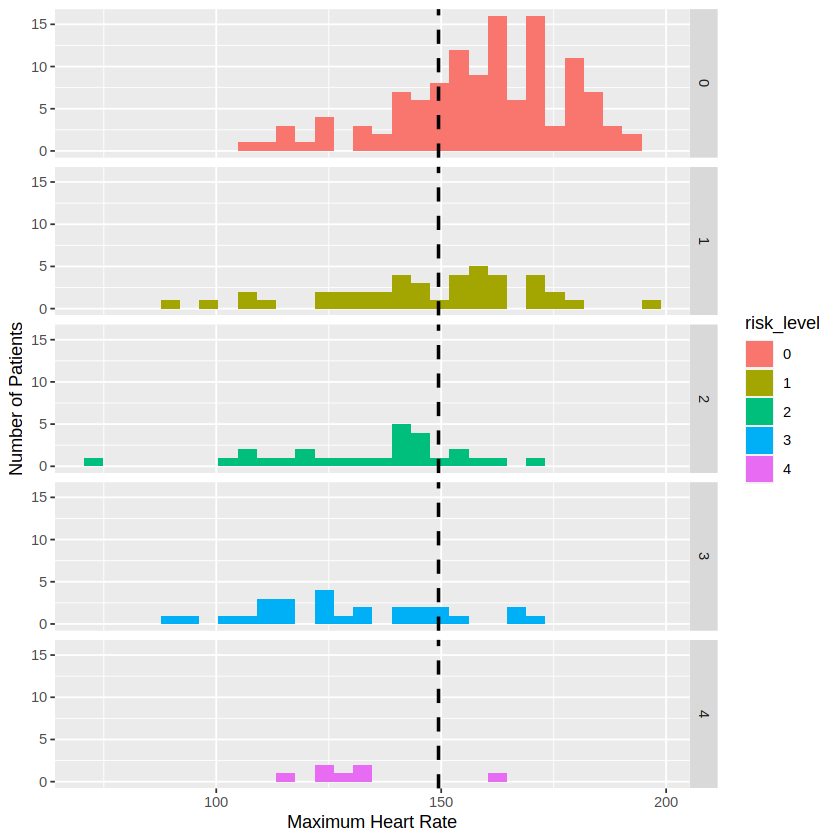

In [3]:
avg_heart_rate <- cleveland_train |>
                summarize(mean = mean(max_heartrate)) |>
                pull()

avg_heart_rate

angina_risk <- cleveland_train |>
                ggplot(aes(max_heartrate, fill = risk_level)) +
                geom_histogram() +
                facet_grid(rows = vars(risk_level)) +
                geom_vline(xintercept = avg_heart_rate, linetype = "dashed", size = 1.0) + 
                labs(x = "Maximum Heart Rate", y = "Number of Patients")

angina_risk

Fig 1: As seen in the bar graphs above, a greater number of patients with max heartrates higher than the avg max heartrate have a lower risk level for heart disease.

In [4]:
heart_data_summary <- cleveland_train |>
                    group_by(risk_level) |>
                    summarize(count = n())
heart_data_summary

risk_level,count
<fct>,<int>
0,121
1,42
2,27
3,27
4,7


Table 1: An analysis table shows the count 